In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append("../")

from tuneavideo.models.unet_with_controlnet import UNet2DConditionModel
from tuneavideo.data.dataset import TuneAVideoMoreShotDataset
from tuneavideo.models.unet import UNet3DConditionModel
from tuneavideo.pipelines.pipeline_tuneavideo import TuneAVideoPipeline
from tuneavideo.pipelines.pipeline_tuneavideo_controlnet_3d import TuneAVideoControlNet3DPipeline
from tuneavideo.pipelines.pipeline_tuneavideo_controlnet import TuneAVideoControlNetPipeline
from diffusers import StableDiffusionPipeline

import torch
from transformers import CLIPTokenizer
import numpy as np
from einops import rearrange
from PIL import Image
from glob import glob

from einops import rearrange
from moviepy import editor

/mnt/disks/disk_main/anaconda3/envs/tune_a_video/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_org = "../../diffusers_controlnet/models/control_sd15_openpose"
path_tav = "../outputs/control_woman_dance/2023-02-20T10-03-52"
path_sd15 = "../checkpoints/sd15"

unet3d = UNet3DConditionModel.from_pretrained_2d(path_tav + "/unet").half().cuda()
controlnet = UNet2DConditionModel.from_pretrained(path_org + "/controlnet").half().cuda()
tuneavideo = TuneAVideoControlNetPipeline.from_pretrained(path_org, unet=unet3d, controlnet=controlnet, torch_dtype=torch.float16).to("cuda")

The config attributes {'conv_in_kernel': 3, 'conv_out_kernel': 3, 'projection_class_embeddings_input_dim': None, 'time_cond_proj_dim': None, 'time_embedding_type': 'positional', 'timestep_post_act': None} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'conv_in_kernel': 3, 'conv_out_kernel': 3, 'projection_class_embeddings_input_dim': None, 'time_cond_proj_dim': None, 'time_embedding_type': 'positional', 'timestep_post_act': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'feature_extractor': ['transformers', 'CLIPFeatureExtractor'], 'requires_safety_checker': True, 'safety_checker': ['stable_diffusion', 'StableDiffusionSafetyChecker']} were passed to TuneAVideoControlNetPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration fi

In [4]:
tuneavideo.unet.enable_xformers_memory_efficient_attention()
tuneavideo.controlnet.enable_xformers_memory_efficient_attention()

In [5]:
path_list = glob("../../ControlNet/data/woman_dance_pose/*")
path_list.sort()
def open_hint(path):
    image = Image.open(path)
    image = image.convert("RGB").resize((512,512))
    return torch.from_numpy(np.asarray(image).copy()).permute(2, 0, 1).half().cuda() / 255.0
hint_list = [open_hint(path) for path in path_list[:16]]

In [6]:
tuneavideo.unet = tuneavideo.unet.to("cuda").half()
tuneavideo.controlnet = tuneavideo.controlnet.to("cuda").half()

In [7]:
def to_np_video(x):
    x = x.squeeze(0)
    print(x.shape)
    x = rearrange(x, "c t h w -> t h w c")
    print(x.shape)
    x = (x * 255).numpy().astype(np.uint8)
    return x


In [8]:
length = 16

""" 
# 3d controlnet
hint_list_un = [h.unsqueeze(0) for h in hint_list[:length]]
hint_cat = torch.cat(hint_list_un, 0)
hint_cat = hint_cat.unsqueeze(0)
hint_cat = rearrange(hint_cat, "b f c h w -> b c f h w")
"""
hint_list_un = [h.unsqueeze(0) for h in hint_list[:length]]
hint_cat = torch.cat(hint_list_un, 0)
print(hint_cat.shape)

torch.Size([16, 3, 512, 512])


In [30]:

torch.manual_seed(0)
v = tuneavideo(
    # prompt="beautiful photo of dancing fireworker, white background, high quality, 4k",
    # negative_prompt="low quality, bad anatomy",
    prompt="high quality photo of a ironman",
    controlnet_hint=hint_cat[:length],
    video_length = length,
    num_inference_steps=50,
    fix_seed_across_frames=True
).videos

v_np = to_np_video(v)
clip = editor.ImageSequenceClip(list(v_np), fps=8)
clip.ipython_display()

100%|██████████| 50/50 [03:26<00:00,  4.13s/it]


torch.Size([3, 16, 512, 512])
torch.Size([16, 512, 512, 3])
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [31]:
clip.write_videofile("../data/out/dancing_firefighter/fix_seed_true.mp4")

Moviepy - Building video ../data/out/dancing_firefighter/fix_seed_true.mp4.
Moviepy - Writing video ../data/out/dancing_firefighter/fix_seed_true.mp4



Moviepy - Done !
Moviepy - video ready ../data/out/dancing_firefighter/fix_seed_true.mp4


In [55]:
res.videos[0].shape

torch.Size([3, 8, 512, 512])

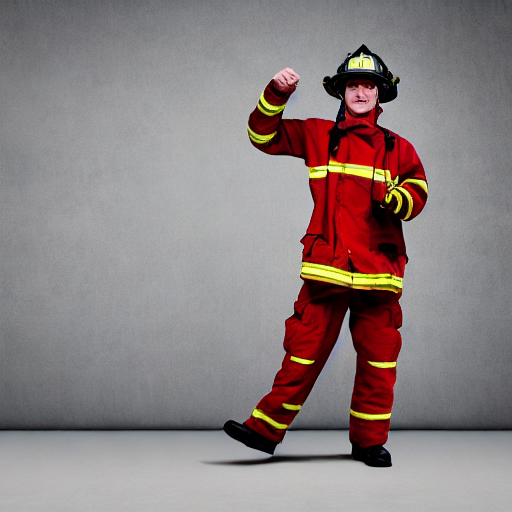

In [49]:
Image.fromarray((res.videos[0].permute(1, 2, 3, 0)[0].cpu().numpy() * 255).astype(np.uint8))

In [50]:
for i in range(res.videos[0].shape[1]):
    Image.fromarray((res.videos[0].permute(1, 2, 3, 0)[i].cpu().numpy() * 255).astype(np.uint8)).save(f"../data/out/dancing_firefighter/{i}.png")
    

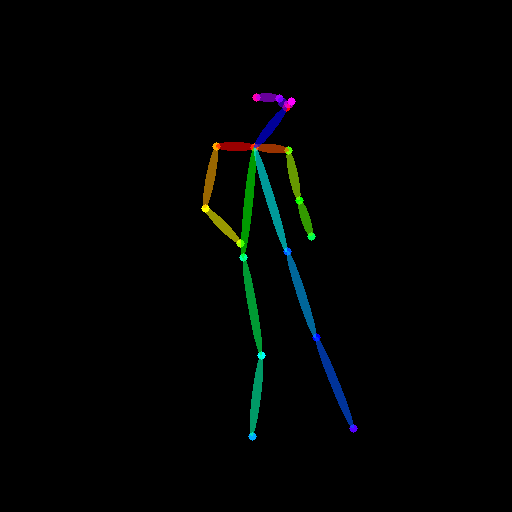

In [25]:
Image.fromarray((hint_cat[1].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

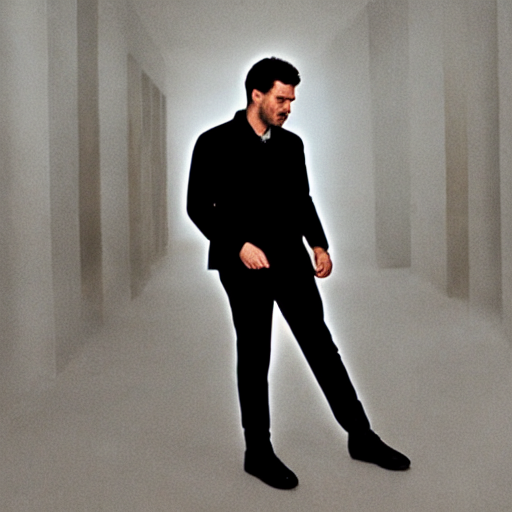

In [22]:
Image.fromarray((res.videos[0].permute(1, 2, 3, 0)[1].cpu().numpy() * 255).astype(np.uint8))

In [ ]:
# controlnet = UNet2DConditionModel.from_config("../../diffusers_controlnet/models/control_sd15_openpose/controlnet/config.json")
# controlnet = UNet2DConditionModel.from_pretrained("../../diffusers_controlnet/models/control_sd15_openpose/controlnet")

In [29]:
latent_model_input = torch.randn(2, 4, 2, 64, 64).cuda().half() # b, c, f, h, w
# latent_model_input_uncond, latent_model_input_text = latent_model_input.chunk(2)
controlnet_input = rearrange(
    latent_model_input, "b c f h w -> f b c h w"
)
# print(controlnet_input.shape)
# x = torch.randn(3, 4, 64, 64).cuda().half()
t = 1

encoder_hidden_states = torch.randn(2, 320, 768).cuda().half()

# uncond_embed, text_embed = encoder_hidden_states.chunk(2)
hint = torch.randn(2, 3, 512, 512).cuda().half()

In [30]:
controlnet_input.shape

torch.Size([2, 2, 4, 64, 64])

In [32]:
control_list = []
for frame in range(controlnet_input.shape[0]):
    inp = controlnet_input[frame].squeeze(0)
    inp_hint = hint[frame].unsqueeze(0)
    print(inp.shape, inp_hint.shape)
    res = controlnet(inp, t, encoder_hidden_states=encoder_hidden_states, controlnet_hint=inp_hint)
    control_list.append(res)

torch.Size([2, 4, 64, 64]) torch.Size([1, 3, 512, 512])
torch.Size([2, 4, 64, 64]) torch.Size([1, 3, 512, 512])


In [40]:
cat_control = []
for idx in range(len(control_list[0])):
    idx_control_item = []
    for control in control_list:
        idx_control_item.append(control[idx].unsqueeze(0))
    cat_item = torch.concat(idx_control_item, dim=0)
    cat_item = rearrange(cat_item, "b f c h w -> b c f h w")
    cat_control.append(cat_item)

In [41]:
cat_control[-10].shape

torch.Size([2, 320, 2, 32, 32])

In [13]:
hoge = torch.randn(2, 2, 2)
moge = torch.randn(2, 2)
(hoge + moge).shape

torch.Size([2, 2, 2])

In [42]:
encoder_hidden_states = torch.randn(2, 320, 768).cuda().half()
res = tuneavideo.unet(
    latent_model_input,
    t,
    encoder_hidden_states=encoder_hidden_states,
    control=cat_control
)

control.pop  torch.Size([2, 1280, 2, 8, 8])
sample  torch.Size([2, 1280, 2, 8, 8])
res_samples
[torch.Size([2, 320, 2, 64, 64]), torch.Size([2, 320, 2, 64, 64]), torch.Size([2, 320, 2, 64, 64]), torch.Size([2, 320, 2, 32, 32]), torch.Size([2, 640, 2, 32, 32]), torch.Size([2, 640, 2, 32, 32]), torch.Size([2, 640, 2, 16, 16]), torch.Size([2, 1280, 2, 16, 16]), torch.Size([2, 1280, 2, 16, 16]), torch.Size([2, 1280, 2, 8, 8]), torch.Size([2, 1280, 2, 8, 8]), torch.Size([2, 1280, 2, 8, 8])]
control_samples
[torch.Size([2, 320, 2, 64, 64]), torch.Size([2, 320, 2, 64, 64]), torch.Size([2, 320, 2, 64, 64]), torch.Size([2, 320, 2, 32, 32]), torch.Size([2, 640, 2, 32, 32]), torch.Size([2, 640, 2, 32, 32]), torch.Size([2, 640, 2, 16, 16]), torch.Size([2, 1280, 2, 16, 16]), torch.Size([2, 1280, 2, 16, 16]), torch.Size([2, 1280, 2, 8, 8]), torch.Size([2, 1280, 2, 8, 8]), torch.Size([2, 1280, 2, 8, 8])]


In [11]:
res[0].shape

torch.Size([2, 4, 3, 64, 64])

In [15]:
rearrange(torch.randn(1, 3, 2, 64, 64), "b c f h w -> (b f) c h w").shape

torch.Size([2, 3, 64, 64])

In [17]:
control_o = [rearrange(c, "(b f) c h w -> b c f h w", b = 1) for c in res]
control_o[0].shape

torch.Size([1, 320, 3, 64, 64])

In [ ]:
path = "../checkpoints/tav_yor_dedede/unet"
# unet = UNet3DConditionModel.from_pretrained(path, torch_dtype=torch.float)
unet = UNet3DConditionModel.from_config(path + "/config.json")

In [ ]:
"""
control = [
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 16, 16),
    torch.randn(1, 1280, 1, 16, 16),
    torch.randn(1, 640, 1, 16, 16),
    torch.randn(1, 640, 1, 32, 32),
    torch.randn(1, 640, 1, 32, 32),
    torch.randn(1, 320, 1, 32, 32),
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 64, 64),
]
"""
control = [
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 32, 32),
    torch.randn(1, 640, 1, 32, 32),
    torch.randn(1, 640, 1, 32, 32),
    torch.randn(1, 640, 1, 16, 16),
    torch.randn(1, 1280, 1, 16, 16),
    torch.randn(1, 1280, 1, 16, 16),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
]

In [ ]:
sample = torch.randn(1, 4, 1, 64, 64)
timestep = 1
encoder_hidden_states = torch.randn(1, 320, 768)
res = unet(sample, timestep, encoder_hidden_states, control = control)

In [ ]:
res.sample.shape